<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li></ul></div>

# Определение возраста покупателей

Сетевому супермаркету необходимо внедрить систему компьютерного зрения для определения возвраста покупателей. С ее помощью можно будет настроить систему рекомендаций для определенных возрастных групп и контролировать продажу алкоголя несовершеннолетним.

**Цель исследования:** Необходимо построить модель, которая определит приблизительный возраст человека на фотографии.

**План исследования:**
* Исследовательский анализ данных
* Обучения модели
* Анализ обученной модели
* Вывод

В нашем распоряжении фотографии и файл `labels.csv` с названиями фотографии и возрастом человека на фотографии.

## Исследовательский анализ данных

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

Взглянем на размер исходной выборки:

In [2]:
labels_df = pd.read_csv('/datasets/faces/labels.csv')
labels_df.shape

(7591, 2)

Данных не так уж и много, модель может переобучиться. Чтобы увеличить размер выборки при обучении, попробуем использовать аугментации.

Получим данные с помощью загрузчика:

In [3]:
def load_train(path):
    data = labels_df
    datagen = ImageDataGenerator(rescale=1./255.)
    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=data,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(256, 256),
        batch_size=16,
        class_mode='raw',
        seed=12345)

    return train_datagen_flow
    

In [4]:
train = load_train('/datasets/faces/')

Found 7591 validated image filenames.


Кол-во фотографий совпадает с кол-вом строк в датафрейме с возрастом, это хорошо

In [5]:
features, target = next(train)

Посмотрим на распределение таргета:

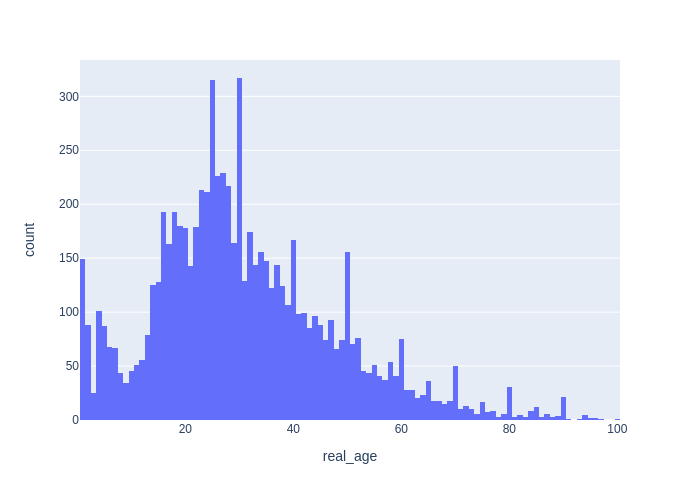

In [6]:
fig = px.histogram(labels_df, x="real_age", nbins=100)
fig.show('png')

В выборке больше всего фотографий 20-30 лет. Так же есть пики значений на круглых годах. Возможно, что при разметке данных неизвестный возраст просто примерно округлялся. Удалить данные нельзя, их и так мало, тогда мы их оставим и запомним, что возможно модель будет склонна тоже округлять возраст.

Выведем первые 15 фото:

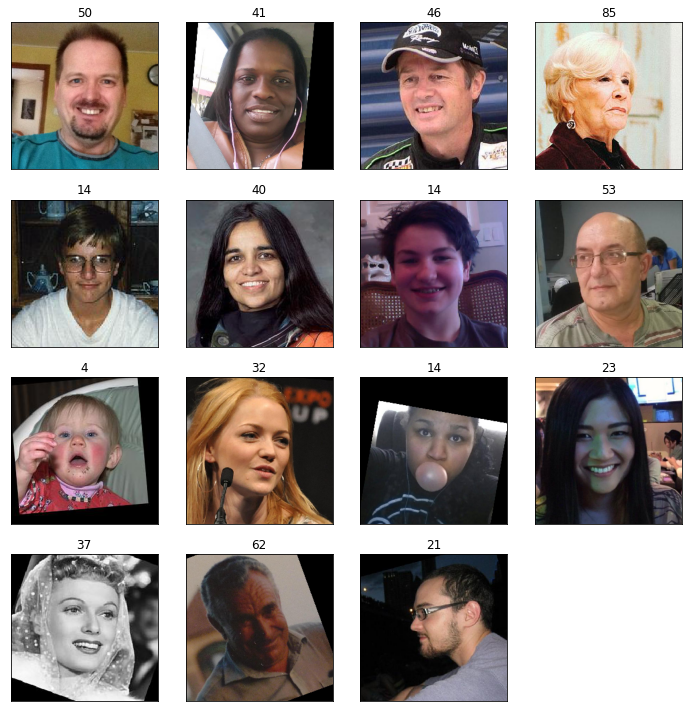

In [7]:
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.title(target[i])
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Вывод

Фотографии разных размеров, с разным углом наклона, какие-то из них цветные, какие-то черно-белые. При выгрузке мы приведем их к общему размеру, добавим небольшой угол наклона и отзеркалим, чтобы увеличить размер выборки

## Обучение модели

Обучать модель будем на архитектуре ResNet50, c `optimizer = Adam(lr=0.0001)`


(Обучение модели происходит в отдельном облаке, поэтому тут не ячейка с кодом, а код в текстовой ячейке)

```python

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd


def load_train(path): # загрузим обучающую выборку
    datagen_train = ImageDataGenerator(rescale=1./255.,   # тут наши аугментации, чтобы модель лучше обучалась
                                 validation_split=0.25,
                                 horizontal_flip=True,
                                 rotation_range=20,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2)
    
    train_datagen_flow = datagen_train.flow_from_dataframe( # "достаем" изображения с помощью загрузчика
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=(path + '/final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        color_mode = 'rgb',
        subset = 'training',
        class_mode='raw',
        seed=12345)

    return train_datagen_flow


def load_test(path): # загружаем тестовую выборку
    datagen_test = ImageDataGenerator(rescale=1. / 255., validation_split=0.25) # уже без аугментаций
    
    test_datagen_flow = datagen_test.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=(path + '/final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        subset='validation',
        class_mode='raw',
        seed=12345)

    return test_datagen_flow



def create_model(input_shape): # тут лежит наша нейронка

    backbone = ResNet50(input_shape=(224, 224, 3),
                        weights='imagenet',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(Flatten())
    model.add(Dense(1024, activation="relu"))
    model.add(Dense(3, activation="relu"))
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=50, # обучение модели
                steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              batch_size=batch_size, verbose=2,
              epochs=epochs)

    return model 


```

Результат:

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.
Train for 178 steps, validate for 60 steps
Epoch 1/50
2022-08-26 14:04:15.183965: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-08-26 14:04:15.642091: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 106s - loss: 200.6771 - mean_absolute_error: 10.6625 - val_loss: 357.0664 - val_mean_absolute_error: 14.0418
Epoch 2/50
178/178 - 93s - loss: 107.9048 - mean_absolute_error: 7.8821 - val_loss: 294.4417 - val_mean_absolute_error: 12.8243
Epoch 3/50
178/178 - 98s - loss: 86.7749 - mean_absolute_error: 7.1538 - val_loss: 288.2230 - val_mean_absolute_error: 12.5879
Epoch 4/50
178/178 - 96s - loss: 64.8784 - mean_absolute_error: 6.2207 - val_loss: 146.5211 - val_mean_absolute_error: 9.0855
Epoch 5/50
178/178 - 94s - loss: 57.3592 - mean_absolute_error: 5.8252 - val_loss: 131.0265 - val_mean_absolute_error: 8.6386
Epoch 6/50
178/178 - 93s - loss: 50.7273 - mean_absolute_error: 5.4409 - val_loss: 104.7858 - val_mean_absolute_error: 7.8111
Epoch 7/50
178/178 - 93s - loss: 44.8773 - mean_absolute_error: 5.0863 - val_loss: 112.0102 - val_mean_absolute_error: 8.0127
Epoch 8/50
178/178 - 93s - loss: 38.9949 - mean_absolute_error: 4.8159 - val_loss: 94.9511 - val_mean_absolute_error: 7.2440
Epoch 9/50
178/178 - 93s - loss: 36.0909 - mean_absolute_error: 4.5624 - val_loss: 83.8298 - val_mean_absolute_error: 6.8555
Epoch 10/50
178/178 - 94s - loss: 31.7412 - mean_absolute_error: 4.3321 - val_loss: 79.0549 - val_mean_absolute_error: 6.5941
Epoch 11/50
178/178 - 93s - loss: 29.4570 - mean_absolute_error: 4.1472 - val_loss: 78.6292 - val_mean_absolute_error: 6.4090
Epoch 12/50
178/178 - 95s - loss: 26.4389 - mean_absolute_error: 3.9173 - val_loss: 80.4249 - val_mean_absolute_error: 6.5209
Epoch 13/50
178/178 - 98s - loss: 24.4117 - mean_absolute_error: 3.7902 - val_loss: 97.5663 - val_mean_absolute_error: 7.2123
Epoch 14/50
178/178 - 98s - loss: 21.3161 - mean_absolute_error: 3.5635 - val_loss: 81.7505 - val_mean_absolute_error: 6.5221
Epoch 15/50
178/178 - 99s - loss: 22.4541 - mean_absolute_error: 3.6274 - val_loss: 71.6040 - val_mean_absolute_error: 6.2815
Epoch 16/50
178/178 - 98s - loss: 20.4131 - mean_absolute_error: 3.4747 - val_loss: 75.5991 - val_mean_absolute_error: 6.6206
Epoch 17/50
178/178 - 94s - loss: 19.6247 - mean_absolute_error: 3.3610 - val_loss: 76.4464 - val_mean_absolute_error: 6.5120
Epoch 18/50
178/178 - 94s - loss: 21.7317 - mean_absolute_error: 3.5370 - val_loss: 82.5474 - val_mean_absolute_error: 6.8692
Epoch 19/50
178/178 - 93s - loss: 19.4990 - mean_absolute_error: 3.3864 - val_loss: 81.6199 - val_mean_absolute_error: 6.4622
Epoch 20/50
178/178 - 93s - loss: 18.3934 - mean_absolute_error: 3.2994 - val_loss: 72.5403 - val_mean_absolute_error: 6.2044
Epoch 21/50
178/178 - 94s - loss: 16.3608 - mean_absolute_error: 3.1190 - val_loss: 70.0980 - val_mean_absolute_error: 6.0686
Epoch 22/50
178/178 - 93s - loss: 16.0545 - mean_absolute_error: 3.0606 - val_loss: 66.2772 - val_mean_absolute_error: 6.1269
Epoch 23/50
178/178 - 91s - loss: 15.9843 - mean_absolute_error: 3.0446 - val_loss: 69.6657 - val_mean_absolute_error: 6.1262
Epoch 24/50
178/178 - 96s - loss: 14.9307 - mean_absolute_error: 2.9560 - val_loss: 71.6316 - val_mean_absolute_error: 6.0755
Epoch 25/50
178/178 - 91s - loss: 15.4243 - mean_absolute_error: 3.0058 - val_loss: 88.5698 - val_mean_absolute_error: 6.8471
Epoch 26/50
178/178 - 92s - loss: 15.9639 - mean_absolute_error: 3.0217 - val_loss: 74.0266 - val_mean_absolute_error: 6.5771
Epoch 27/50
178/178 - 95s - loss: 15.5264 - mean_absolute_error: 2.9966 - val_loss: 71.1864 - val_mean_absolute_error: 6.3424
Epoch 28/50
178/178 - 90s - loss: 14.3358 - mean_absolute_error: 2.8842 - val_loss: 71.2844 - val_mean_absolute_error: 6.2642
Epoch 29/50
178/178 - 89s - loss: 14.9709 - mean_absolute_error: 2.9481 - val_loss: 80.9606 - val_mean_absolute_error: 6.5206
Epoch 30/50
178/178 - 90s - loss: 14.1330 - mean_absolute_error: 2.8796 - val_loss: 72.1399 - val_mean_absolute_error: 6.1746
Epoch 31/50
178/178 - 89s - loss: 13.3650 - mean_absolute_error: 2.8281 - val_loss: 76.2218 - val_mean_absolute_error: 6.5182
Epoch 32/50
178/178 - 89s - loss: 14.2116 - mean_absolute_error: 2.8685 - val_loss: 83.9322 - val_mean_absolute_error: 6.7783
Epoch 33/50
178/178 - 92s - loss: 13.7810 - mean_absolute_error: 2.8190 - val_loss: 66.6388 - val_mean_absolute_error: 6.0972
Epoch 34/50
178/178 - 91s - loss: 12.7348 - mean_absolute_error: 2.7307 - val_loss: 69.5108 - val_mean_absolute_error: 6.0150
Epoch 35/50
178/178 - 92s - loss: 11.7692 - mean_absolute_error: 2.6291 - val_loss: 68.0192 - val_mean_absolute_error: 6.1550
Epoch 36/50
178/178 - 101s - loss: 12.3978 - mean_absolute_error: 2.6746 - val_loss: 63.4002 - val_mean_absolute_error: 5.8058
Epoch 37/50
178/178 - 105s - loss: 11.9325 - mean_absolute_error: 2.6105 - val_loss: 69.1226 - val_mean_absolute_error: 6.1822
Epoch 38/50
178/178 - 104s - loss: 11.6965 - mean_absolute_error: 2.6013 - val_loss: 68.6158 - val_mean_absolute_error: 6.0377
Epoch 39/50
178/178 - 106s - loss: 11.4080 - mean_absolute_error: 2.5704 - val_loss: 75.7144 - val_mean_absolute_error: 6.5421
Epoch 40/50
178/178 - 104s - loss: 11.1777 - mean_absolute_error: 2.5284 - val_loss: 65.9208 - val_mean_absolute_error: 5.9398
Epoch 41/50
178/178 - 105s - loss: 11.4531 - mean_absolute_error: 2.5548 - val_loss: 66.7922 - val_mean_absolute_error: 6.0856
Epoch 42/50
178/178 - 100s - loss: 11.1417 - mean_absolute_error: 2.5257 - val_loss: 76.9466 - val_mean_absolute_error: 6.2612
Epoch 43/50
178/178 - 95s - loss: 27.2877 - mean_absolute_error: 3.7240 - val_loss: 94.3871 - val_mean_absolute_error: 7.2000
Epoch 44/50
178/178 - 94s - loss: 19.1076 - mean_absolute_error: 3.3053 - val_loss: 73.5936 - val_mean_absolute_error: 6.1990
Epoch 45/50
178/178 - 94s - loss: 13.2738 - mean_absolute_error: 2.7799 - val_loss: 66.0707 - val_mean_absolute_error: 6.0980
Epoch 46/50
178/178 - 90s - loss: 10.3232 - mean_absolute_error: 2.4541 - val_loss: 61.7795 - val_mean_absolute_error: 5.7746
Epoch 47/50
178/178 - 90s - loss: 9.4090 - mean_absolute_error: 2.3361 - val_loss: 64.2403 - val_mean_absolute_error: 5.9011
Epoch 48/50
178/178 - 90s - loss: 8.6789 - mean_absolute_error: 2.2435 - val_loss: 68.7362 - val_mean_absolute_error: 6.0070
Epoch 49/50
178/178 - 90s - loss: 8.3845 - mean_absolute_error: 2.2019 - val_loss: 70.0265 - val_mean_absolute_error: 6.3455
Epoch 50/50
178/178 - 90s - loss: 7.5498 - mean_absolute_error: 2.0961 - val_loss: 62.6211 - val_mean_absolute_error: 5.7316
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 62.6211 - mean_absolute_error: 5.7316
Test MAE: 5.7316

```

## Анализ обученной модели

Мы использовали модель с параметрами:
* optimizer = `Adam(lr=0.0001)`
* функия потерь - `MSE`
* Архитектура ResNet50 с  `weights='imagenet'`
* один полносвязный слой 1024 нейрона с активацией `relu`
* второй полносвязный слой с 5 нейронами с активацией `relu`
* 50 эпох


Финальная метрика - MAE, результат 5.7

Если учитывать, что модель может ошибиться на 6 лет, то точно можно говорить о том, что полность отдавать ей контроль за продажей товаров несовершеннолетним нельзя. Кроме того, нужно провести дополнительные тесты на разных возрастных группах, возможно модель легко отличит 15 и 21 год, а вот с 20-30 лет у нее будут проблемы. 

Может точный возраст модель и не всегда может угадать, но легко должна справиться с определением возрастной группы покупателя, что поможет отслеживать покупки определенной возрастной группы и настроить систему рекомендаций.